In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import math
import seaborn as sns

2022-12-16 09:35:56.056990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 09:35:56.206646: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-12-16 09:35:57.785090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 09:35:57.802839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 09:35:57.803058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
#importing models from previous folder
from models import control_ma,control_tapper,complex,complex_wide,our_simple,our_simp_comp

In [4]:
#defining variables for model factory and name
control_ma_info = {"name":"control_ma","pipe":control_ma.Control}
control_tapper_info = {"name":"control_tapper","pipe":control_tapper.Control}
complex_info = {"name":"complex","pipe":complex.ComplexModel}
complex_wide_info = {"name":"complex_wide","pipe":complex_wide.ComplexModel}
our_simp_info = {"name":"our_simp","pipe":our_simple.ComplexModel}
our_simp_comp_info = {"name":"our_simp_comp","pipe":our_simp_comp.ComplexModel}

In [5]:
## apply FPC to data using argument pipe (note - important to know what is the range used)
def apply_fpc(input_fids,pipe,t,starting_sp=728):
    fids = input_fids.copy()
    # 1752-728

    freq_pred_spec = np.fft.fftshift(np.fft.ifft(fids,axis=1),axes=1)
    freq_pred_spec = freq_pred_spec[:,starting_sp:(starting_sp+1024),:,:]

    freq_results = pipe.predict_freq(freq_pred_spec).reshape(fids.shape[0],1,1,-1)

    fids = fids*np.exp(1j*freq_results*2*math.pi*t.reshape(1,-1,1,1))

    phase_pred_spec = np.fft.fftshift(np.fft.ifft(fids,axis=1),axes=1)
    phase_pred_spec = phase_pred_spec[:,starting_sp:(starting_sp+1024),:,:]

    phase_results = pipe.predict_phase(phase_pred_spec).reshape(fids.shape[0],1,1,-1)

    fids = fids*np.exp(1j*phase_results*math.pi/180)

    return fids

In [6]:
# calculate fwhm of peak in specific range (nor sure 100% correct)
def calc_fwhms(spectra,ppm,ppm_min,ppm_max):
    freqInt = np.where((ppm <= ppm_max) & (ppm >= ppm_min))
    
    medians = np.median(spectra,axis=1)
    
    range_spectrum = spectra[:,freqInt[0][0]:freqInt[0][-1]]
    range_ppm = ppm[freqInt[0][0]:freqInt[0][-1]]

    maxes = range_spectrum.max(axis=1)

    over_half_range = (range_spectrum-medians.reshape(-1,1)>=((maxes-medians)/2).reshape(-1,1))

    output_fwhms=np.zeros(spectra.shape[0])

    for i in range(spectra.shape[0]):
        freqInt2 = np.where(over_half_range[i]==True)
        if(freqInt2[0].shape[0]==0):
            max_ppm_ind = 0
            min_ppm_ind = freqInt2.shape[0]-1
        elif (freqInt2[0].shape[0]==1):
            max_ppm_ind = max(freqInt2[0][0]-1,0)
            min_ppm_ind = min(freqInt2[0][0]+1,range_ppm.shape[0]-1)
        else:
            #print(freqInt2)
            max_ppm_ind = max(freqInt2[0][0]-1,0)
            min_ppm_ind = min(freqInt2[0][-1]+1,range_ppm.shape[0]-1) #  we need to define if we use the point right before or after the max_ppm range

        min_ppm = range_ppm[min_ppm_ind]
        max_ppm = range_ppm[max_ppm_ind] 
        output_fwhms[i]=(max_ppm-min_ppm)
    
    return output_fwhms

    

In [7]:
## calculate SNR of given ppm range
def calc_snr(spectra,ppm,ppm_min,ppm_max):

    output_snrs = np.zeros(spectra.shape[0])

    for i in range(spectra.shape[0]):
        indClose, indFar = np.amax(np.where(ppm >= ppm_min)), np.amin(np.where(ppm <= ppm_max))
        dt_indClose, dt_indFar = np.amax(np.where(ppm >= 10.0)), np.amin(np.where(ppm <= 12))
        
        max_peak = np.amax(spectra[i,indFar:indClose])
        # Std Dev of Noise
        dt = np.polyfit(ppm[dt_indFar:dt_indClose], ppm[dt_indFar:dt_indClose], 2)
        
        sizeFreq = ppm[dt_indFar:dt_indClose].shape[0]
        #stdev_Man = np.real(spectra[i,dt_indFar:dt_indClose]).std()#= np.sqrt(np.sum(np.square(np.real(i_spec[dt_indFar:dt_indClose] - 0*np.polyval(dt, i_ppm[dt_indFar:dt_indClose])))) / (sizeFreq - 1))
        stdev_Man = np.sqrt(np.sum(np.square(np.real(spectra[i,dt_indFar:dt_indClose] - np.polyval(dt, ppm[dt_indFar:dt_indClose])))) / (sizeFreq - 1))
        snr = np.real(max_peak) / (2 * stdev_Man)

        output_snrs[i]=snr  
    return output_snrs     

In [15]:
t = np.load("data/in_vivo_datasets/t.npy")
ppm = np.load("data/in_vivo_datasets/ppm.npy")


## Metrics for
water_suppression="unsup"
model_snr="2_5"
training_run=1

scans = []
offset_labels=[]
cho_stds = []
models=[]
on_cr_fwhms=[]
off_cr_fwhms=[]
gaba_fwhms=[]
on_cr_snrs=[]
off_cr_snrs=[]
gaba_snrs=[]


for offset_label in [0,1,2,3]:
    raw_fids = np.load(f"data/in_vivo_datasets/in_vivo_{offset_label}.npy")

    for model in [complex_info,control_ma_info,control_tapper_info,complex_wide_info,our_simp_info,our_simp_comp_info]:
        pipe_off = model["pipe"]()
        pipe_off.load_model_from_weights(f"models/saved_weights/{model['name']}_freq_unsup_{model_snr}_{training_run}.h5",f"models/saved_weights/{model['name']}_phase_unsup_{model_snr}_{training_run}.h5")
        off_fids = apply_fpc(raw_fids[:,:,:1,:],pipe_off,t)

        pipe_on = model["pipe"]()
        pipe_on.load_model_from_weights(f"models/saved_weights/{model['name']}_freq_unsup_{model_snr}_{training_run}.h5",f"models/saved_weights/{model['name']}_phase_unsup_{model_snr}_{training_run}.h5")
        on_fids = apply_fpc(raw_fids[:,:,1:,:],pipe_on,t)

        off_specs = np.real(np.fft.fftshift(np.fft.ifft(off_fids,axis=1),axes=1).mean(axis=3))
        on_specs = np.real(np.fft.fftshift(np.fft.ifft(on_fids,axis=1),axes=1).mean(axis=3))
        diff_specs = on_specs-off_specs

        ###calculate choline artifact std
        freqInt = np.where((ppm <= 3.285) & (ppm >= 3.15))
        cho_std = diff_specs[:,freqInt[0][0]:freqInt[0][-1],0].reshape(diff_specs.shape[0],-1).std(axis=1)

        ###calculate linewidths
        cr_on_fwhm = calc_fwhms(np.squeeze(on_specs),ppm,2.8,3.2)
        cr_off_fwhm = calc_fwhms(np.squeeze(off_specs),ppm,2.8,3.2)
        gaba_fwhm = calc_fwhms(np.squeeze(diff_specs),ppm,2.8,3.2)

        ###
        cr_on_snr = calc_snr(np.squeeze(on_specs),ppm,2.8,3.2)
        cr_off_snr = calc_snr(np.squeeze(off_specs),ppm,2.8,3.2)
        gaba_snr = calc_snr(np.squeeze(diff_specs),ppm,2.8,3.2)
    

        size = cho_std.shape[0]
        scans += list(range(1,size+1))
        offset_labels+=[offset_label]*size
        cho_stds+=list(cho_std)
        on_cr_fwhms+=list(cr_on_fwhm)
        off_cr_fwhms+=list(cr_off_fwhm)
        gaba_fwhms+=list(gaba_fwhm)
        on_cr_snrs+=list(cr_on_snr)
        off_cr_snrs+=list(cr_off_snr)
        gaba_snrs+=list(gaba_snr)
        models+=[model["name"]]*size  


metrics_df = pd.DataFrame({
    "scan":scans,
    "offset_label":offset_labels,
    "model":models,
    "cho_std":cho_stds,
    "on_cr_fwhm":on_cr_fwhms,
    "off_cr_fwhm":off_cr_fwhms,
    "gaba_fwhm":gaba_fwhms,
    "on_cr_snr":on_cr_snrs,
    "off_cr_snr":off_cr_snrs,
    "gaba_snr":gaba_snrs
})

In [16]:
##### making qscore df

smaller_is_better_cols=["cho_std","on_cr_fwhm","off_cr_fwhm","gaba_fwhm"]

models = ["complex","control_ma","control_tapper","complex_wide","our_simp_comp","our_simp"]

used_a_models=[]

dfs=[]

for model_a in models:
    used_a_models.append(model_a)
    for model_b in models:
        if model_b in used_a_models:
            continue

        a_df = metrics_df[metrics_df["model"]==model_a].copy()
        b_df = metrics_df[metrics_df["model"]==model_b].copy()


        df = pd.DataFrame()
        for col in list(a_df.columns):
            if col in ["scan","offset_label"]:
                df[col] = a_df[col]
            elif col=="model":
                continue
            elif col in smaller_is_better_cols:
                df[col] = 1 - np.square(a_df[col].values)/(np.square(a_df[col].values)+np.square(b_df[col].values))
            else:
                df[col] = 1 - np.square(b_df[col].values)/(np.square(a_df[col].values)+np.square(b_df[col].values))

        df["model_a"]=model_a
        df["model_b"]=model_b

        dfs.append(df)

q_metric_df = pd.concat(dfs,sort=False)

Q = 0.48 +- 0.06 ; P = 44.4%
Q = 0.5 +- 0.04 ; P = 50.0%
Q = 0.5 +- 0.03 ; P = 47.2%
Q = 0.49 +- 0.09 ; P = 41.7%
-----
Q = 0.5 +- 0.08 ; P = 61.1%
Q = 0.5 +- 0.08 ; P = 50.0%
Q = 0.51 +- 0.07 ; P = 61.1%
Q = 0.48 +- 0.11 ; P = 50.0%
-----
Q = 0.52 +- 0.08 ; P = 52.8%
Q = 0.51 +- 0.08 ; P = 44.4%
Q = 0.52 +- 0.07 ; P = 69.4%
Q = 0.49 +- 0.1 ; P = 47.2%
-----


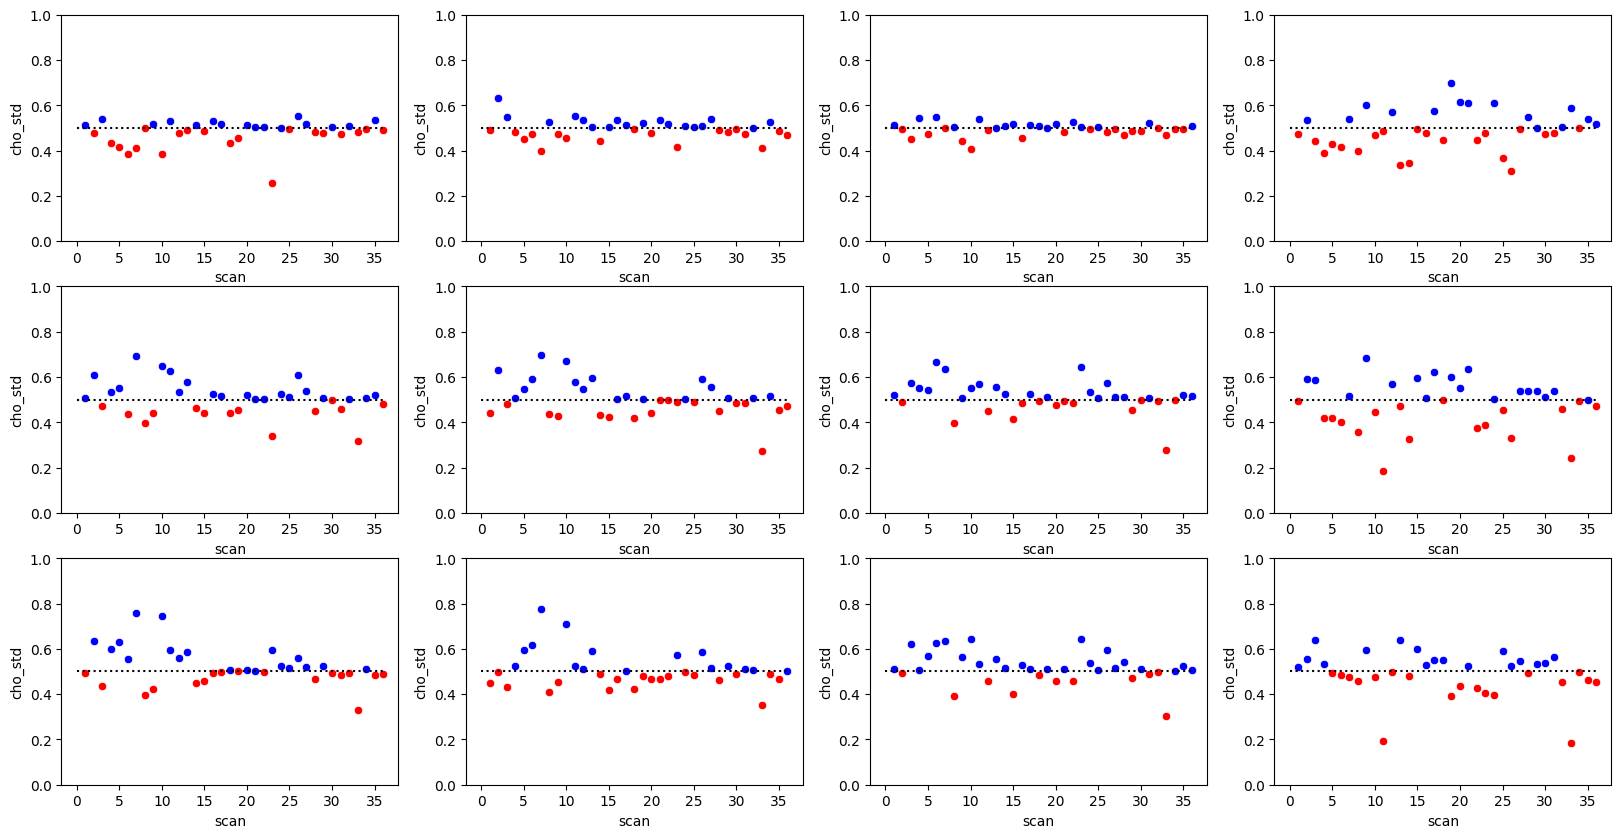

In [18]:
### Graph for Cho Artifact analysis (example that is in Ma and Tapper)

models = [("complex","control_ma"),("complex","control_tapper"),("control_ma","control_tapper")]

models = [("complex","complex_wide"),("complex","our_simp_comp"),("complex_wide","our_simp_comp")]

fig,ax = plt.subplots(3,4,figsize=(20,10))

q_score_col = "cho_std"

for row in range(0,3):
    for col in range(0,4):
        i_df = q_metric_df[(q_metric_df["model_a"]==models[row][0])&(q_metric_df["model_b"]==models[row][1])&(q_metric_df["offset_label"]==col)].copy()
        i_df["color"] = i_df.apply(lambda x: "blue" if x[q_score_col]>0.5 else "red",axis=1)

        my_pallette = {q_score: "blue" if q_score >0.5 else "red" for q_score in i_df[q_score_col].unique()}
        sns.scatterplot(ax=ax[row,col],data = i_df[i_df["color"]=="blue"], x = "scan",y=q_score_col,color="blue")
        sns.scatterplot(ax=ax[row,col],data = i_df[i_df["color"]=="red"], x = "scan",y=q_score_col,color="red")
        ax[row,col].set_ylim(0,1)
        ax[row,col].hlines(0.5,0,36,color='k',linestyle=":")
        print(f"Q = {round(i_df[q_score_col].mean(),2)} +- {round(i_df[q_score_col].std(),2)} ; P = {round(100*i_df[i_df['color']=='blue'].shape[0]/i_df.shape[0],1)}%")
    print("-----")
plt.show()        

Q = 0.48 +- 0.08 ; P = 22.2%
Q = 0.5 +- 0.06 ; P = 30.6%
Q = 0.5 +- 0.06 ; P = 30.6%
Q = 0.5 +- 0.06 ; P = 22.2%
-----
Q = 0.49 +- 0.07 ; P = 33.3%
Q = 0.5 +- 0.07 ; P = 38.9%
Q = 0.48 +- 0.1 ; P = 30.6%
Q = 0.51 +- 0.13 ; P = 47.2%
-----
Q = 0.51 +- 0.05 ; P = 41.7%
Q = 0.5 +- 0.07 ; P = 47.2%
Q = 0.48 +- 0.09 ; P = 33.3%
Q = 0.51 +- 0.13 ; P = 44.4%
-----


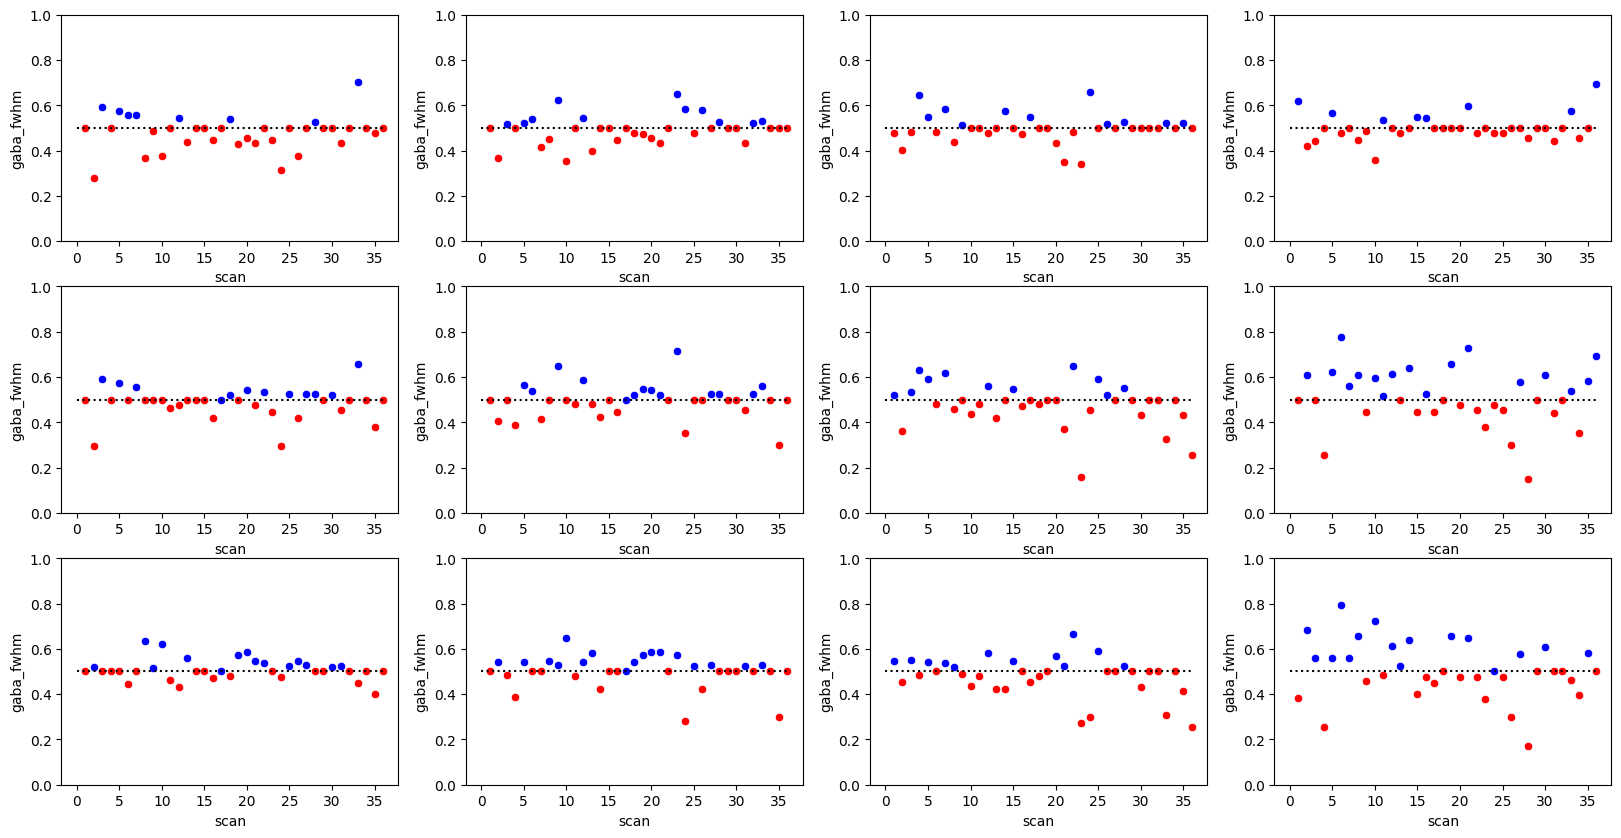

In [13]:
### General graph for other metrics, just change variable q_score_col

q_score_col = "gaba_fwhm"

models = [("complex","control_ma"),("complex","control_tapper"),("control_ma","control_tapper")]

fig,ax = plt.subplots(3,4,figsize=(20,10))


for row in range(0,3):
    for col in range(0,4):
        i_df = q_metric_df[(q_metric_df["model_a"]==models[row][0])&(q_metric_df["model_b"]==models[row][1])&(q_metric_df["offset_label"]==col)].copy()
        i_df["color"] = i_df.apply(lambda x: "blue" if x[q_score_col]>0.5 else "red",axis=1)

        my_pallette = {q_score: "blue" if q_score >0.5 else "red" for q_score in i_df[q_score_col].unique()}
        sns.scatterplot(ax=ax[row,col],data = i_df[i_df["color"]=="blue"], x = "scan",y=q_score_col,color="blue")
        sns.scatterplot(ax=ax[row,col],data = i_df[i_df["color"]=="red"], x = "scan",y=q_score_col,color="red")
        ax[row,col].set_ylim(0,1)
        ax[row,col].hlines(0.5,0,36,color='k',linestyle=":")
        print(f"Q = {round(i_df[q_score_col].mean(),2)} +- {round(i_df[q_score_col].std(),2)} ; P = {round(100*i_df[i_df['color']=='blue'].shape[0]/i_df.shape[0],1)}%")
    print("-----")
plt.show()     

In [14]:
### Same as last cell, but comparting complex to complex_long and control_ma

q_score_col = "off_cr_fwhm"

models = [("complex","complex_long"),("complex","control_ma"),("complex_long","control_ma")]

fig,ax = plt.subplots(3,4,figsize=(20,10))


for row in range(0,3):
    for col in range(0,4):
        i_df = q_metric_df[(q_metric_df["model_a"]==models[row][0])&(q_metric_df["model_b"]==models[row][1])&(q_metric_df["offset_label"]==col)].copy()
        i_df["color"] = i_df.apply(lambda x: "blue" if x[q_score_col]>0.5 else "red",axis=1)

        my_pallette = {q_score: "blue" if q_score >0.5 else "red" for q_score in i_df[q_score_col].unique()}
        sns.scatterplot(ax=ax[row,col],data = i_df[i_df["color"]=="blue"], x = "scan",y=q_score_col,color="blue")
        sns.scatterplot(ax=ax[row,col],data = i_df[i_df["color"]=="red"], x = "scan",y=q_score_col,color="red")
        ax[row,col].set_ylim(0,1)
        ax[row,col].hlines(0.5,0,36,color='k',linestyle=":")
        print(f"Q = {round(i_df[q_score_col].mean(),2)} +- {round(i_df[q_score_col].std(),2)} ; P = {round(100*i_df[i_df['color']=='blue'].shape[0]/i_df.shape[0],1)}%")
    print("-----")
plt.show() 

ZeroDivisionError: division by zero

In [1]:
print(metrics_df["scan"].unique())

NameError: name 'metrics_df' is not defined